# Import Libraries

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Define CNN Layers

In [ ]:
class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Initialization for weights: Helps with proper gradient flow
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * np.sqrt(2.0 / (in_channels * kernel_size * kernel_size))
        self.bias = np.zeros(out_channels)

    # Forward Pass: Computes the output feature map after applying convolution.
    def forward(self, x):
        # Get input dimensions
        batch_size, in_channels, height, width = x.shape
        # Apply padding: Adds zeros around the input feature map
        padded_x = np.pad(x, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
        # Compute output dimensions based on convolution formula
        out_height = (height + 2 * self.padding - self.kernel_size) // self.stride + 1
        out_width = (width + 2 * self.padding - self.kernel_size) // self.stride + 1
        # Initialize output tensor with zeros
        output = np.zeros((batch_size, self.out_channels, out_height, out_width))

        # Perform convolution operation
        for b in range(batch_size):  # Iterate over batch
            for oc in range(self.out_channels):  # Iterate over output channels (filters)
                for oh in range(out_height):  # Iterate over output height
                    for ow in range(out_width):  # Iterate over output width
                        # Define region of interest in the input
                        h_start = oh * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = ow * self.stride
                        w_end = w_start + self.kernel_size

                        # Perform element-wise multiplication between filter and input region
                        # Sum the values and add bias
                        output[b, oc, oh, ow] = np.sum(padded_x[b, :, h_start:h_end, w_start:w_end] * self.weights[oc]) + self.bias[oc]

        # Store input for use in backpropagation
        self.x = padded_x
        return output

    # Backward Pass: Computes gradients of weights and biases
    def backward(self, grad_output, learning_rate):
        # grad_output: Gradient of loss with respect to output of this layer (batch_size, out_channels, out_height, out_width)
        batch_size, out_channels, out_height, out_width = grad_output.shape

        # Initialize gradients for weights, bias, and input
        grad_weights = np.zeros_like(self.weights)  # Gradient w.r.t weights
        grad_bias = np.zeros_like(self.bias)  # Gradient w.r.t bias
        grad_input = np.zeros_like(self.x)  # Gradient w.r.t input

        # Compute gradients
        for b in range(batch_size):  # Iterate over batch
            for oc in range(out_channels):  # Iterate over output channels
                for oh in range(out_height):  # Iterate over output height
                    for ow in range(out_width):  # Iterate over output width
                        # Define region of interest in the padded input
                        h_start = oh * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = ow * self.stride
                        w_end = w_start + self.kernel_size

                        # Compute gradient of weights (dL/dW)
                        # grad_output[b, oc, oh, ow] represents how much the output at (oh, ow) affects the loss
                        grad_weights[oc] += grad_output[b, oc, oh, ow] * self.x[b, :, h_start:h_end, w_start:w_end]

                        # Compute gradient of bias (dL/db)
                        grad_bias[oc] += grad_output[b, oc, oh, ow]

                        # Compute gradient of input (dL/dX)
                        # Identify the input region that contributed to this output pixel.
                        # Distribute the gradient back to this region by multiplying the filter weights by grad_output[b, oc, oh, ow]
                        # The update added to grad_input at this region:
                        grad_input[b, :, h_start:h_end, w_start:w_end] += grad_output[b, oc, oh, ow] * self.weights[oc]

        # Update weights and bias using gradient descent
        self.weights -= learning_rate * grad_weights
        self.bias -= learning_rate * grad_bias

        # Return the gradient of input after removing padding
        return grad_input[:, :, self.padding:self.x.shape[2]-self.padding, self.padding:self.x.shape[3]-self.padding]

class ReLU:
    # Forward Pass: Applies the ReLU activation function element-wise.
    def forward(self, x):
        self.x = x  # Store input for use in backward pass
        return np.maximum(0, x)  # Apply ReLU: max(0, x)

    # Backward Pass: Computes the gradient of the loss w.r.t the input.
    def backward(self, grad_output, learning_rate):
        return grad_output * (self.x > 0)  # Gradient is 1 where x > 0, otherwise 0


class MaxPool2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size  # Size of the pooling window
        self.stride = stride  # Step size for the pooling operation

    # Forward Pass: Applies max pooling to the input feature maps.
    def forward(self, x):
        # Extract input dimensions
        batch_size, in_channels, height, width = x.shape

        # Compute output dimensions after pooling
        out_height = (height - self.pool_size) // self.stride + 1
        out_width = (width - self.pool_size) // self.stride + 1

        # Initialize output tensor with zeros
        output = np.zeros((batch_size, in_channels, out_height, out_width))

        # Apply max pooling operation
        for b in range(batch_size):  # Iterate over batches
            for ic in range(in_channels):  # Iterate over input channels
                for oh in range(out_height):  # Iterate over output height
                    for ow in range(out_width):  # Iterate over output width
                        # Define pooling window boundaries
                        h_start = oh * self.stride
                        h_end = h_start + self.pool_size
                        w_start = ow * self.stride
                        w_end = w_start + self.pool_size

                        # Perform max pooling by selecting the maximum value in the region
                        output[b, ic, oh, ow] = np.max(x[b, ic, h_start:h_end, w_start:w_end])

        # Store input for use in backward pass
        self.x = x
        return output

    # Backward Pass: Computes the gradient of the loss w.r.t the input.
    def backward(self, grad_output, learning_rate):
        # grad_output: Gradient of loss w.r.t output of this layer (same shape as pooled output)
        batch_size, in_channels, out_height, out_width = grad_output.shape # Extract dimensions

        # Initialize gradient tensor with zeros
        grad_input = np.zeros_like(self.x)

        # Compute gradient propagation for max pooling
        for b in range(batch_size):  # Iterate over batches
            for ic in range(in_channels):  # Iterate over input channels
                for oh in range(out_height):  # Iterate over output height
                    for ow in range(out_width):  # Iterate over output width
                        # Define pooling window boundaries
                        h_start = oh * self.stride
                        h_end = h_start + self.pool_size
                        w_start = ow * self.stride
                        w_end = w_start + self.pool_size

                        # Extract the pooling region from input
                        pool_region = self.x[b, ic, h_start:h_end, w_start:w_end]

                        # Identify the max value in the pooling region
                        max_val = np.max(pool_region)

                        # Assign gradients only to the max value positions
                        for ih in range(h_start, h_end):
                            for iw in range(w_start, w_end):
                                if self.x[b, ic, ih, iw] == max_val:
                                    grad_input[b, ic, ih, iw] = grad_output[b, ic, oh, ow]
                                else:
                                    grad_input[b, ic, ih, iw] = 0  # Zero gradient for non-max elements

        return grad_input


# Forward Pass: Flattens a multi-dimensional input (excluding batch dimension) into a 1D vector.
class Flatten:
    def forward(self, x):
        # Store original shape for use in the backward pass
        self.shape = x.shape
        return x.reshape(x.shape[0], -1)

    # Backward Pass: Reshapes the gradient back to the original input shape.
    def backward(self, grad_output, learning_rate):
        # Reshape gradient back to the original input shape before flattening
        return grad_output.reshape(self.shape)

class Dense:
    def __init__(self, in_features, out_features):
        self.weights = np.random.randn(in_features, out_features) * np.sqrt(2.0 / in_features)
        self.bias = np.zeros(out_features)  # Bias initialized to zeros

    # Forward Pass: Computes the linear transformation `Wx + b`.
    def forward(self, x):
        self.x = x  # Store input for use in the backward pass
        return np.dot(x, self.weights) + self.bias  # Matrix multiplication + bias

    # Backward Pass: Computes gradients and updates weights using gradient descent.
    def backward(self, grad_output, learning_rate):
        # grad_output: Gradient of the loss w.r.t. the output
        grad_weights = np.dot(self.x.T, grad_output)  # Compute gradient for weights
        grad_bias = np.sum(grad_output, axis=0)  # Compute gradient for bias
        grad_input = np.dot(grad_output, self.weights.T)  # Compute gradient for input

        # Update weights and bias using gradient descent
        self.weights -= learning_rate * grad_weights
        self.bias -= learning_rate * grad_bias

        return grad_input  # Pass gradients back to the previous layer


class Softmax:
    # Forward Pass: Computes the Softmax activation function.
    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract max for numerical stability
        self.probs = exp_x / np.sum(exp_x, axis=1, keepdims=True)  # Normalize probabilities
        return self.probs  # Each row represents a probability distribution

    # Backward Pass: Computes the gradient of the loss w.r.t. the input.
    def backward(self, grad_output, learning_rate):
        return self.probs * grad_output - np.mean(self.probs * grad_output, axis=1, keepdims=True)

# Define CNN Model

In [ ]:
import numpy as np

class CNN:
    def __init__(self):
        self.layers = [
            Conv2D(1, 4, 3, padding=1),   # Convolution layer (input: 1 channel, output: 4 channels)
            ReLU(),                       # ReLU activation
            MaxPool2D(),                  # Max pooling (default 2x2 stride)
            Conv2D(4, 8, 3, padding=1),   # Convolution layer (input: 4 channels, output: 8 channels)
            ReLU(),                       # ReLU activation
            MaxPool2D(),                  # Max pooling (default 2x2 stride)
            Flatten(),                    # Flatten layer to convert 2D feature maps to 1D vector
            Dense(8 * 2 * 2, 10),         # Fully connected layer (input: flattened features, output: 10)
            Softmax()                    # Softmax activation for classification
        ]

    # Performs a forward pass through all layers of the CNN.
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)  # Pass input through each layer sequentially
        return x

    # Performs backpropagation through all layers in reverse order.
    def backward(self, grad_output, learning_rate):
        # grad_output: Gradient of loss w.r.t. output of the CNN
        # learning_rate: Step size for weight updates
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output, learning_rate)  # Backpropagate gradient through each layer

    def train(self, x_train, y_train, x_val, y_val, epochs, learning_rate):
        train_losses = []  # Stores training loss per epoch
        val_losses = []    # Stores validation loss per epoch

        for epoch in range(epochs):
            epoch_train_loss = 0

            # Training loop
            for i in range(len(x_train)):
                x = x_train[i].reshape(1, 1, 8, 8)  # Reshape to (batch_size=1, channels=1, height=8, width=8)
                y = y_train[i].reshape(1, 10)  # One-hot encoded labels

                output = self.forward(x)  # Forward pass
                loss = -np.sum(y * np.log(output))  # Cross-entropy loss
                epoch_train_loss += loss

                grad_output = output - y  # Compute gradient of loss w.r.t. softmax output
                self.backward(grad_output, learning_rate)  # Backpropagation

            train_losses.append(epoch_train_loss / len(x_train))  # Average training loss per epoch

            # Validation loop
            epoch_val_loss = 0
            for i in range(len(x_val)):
                x = x_val[i].reshape(1, 1, 8, 8)
                y = y_val[i].reshape(1, 10)

                output = self.forward(x)  # Forward pass on validation set
                loss = -np.sum(y * np.log(output))  # Cross-entropy loss
                epoch_val_loss += loss

            val_losses.append(epoch_val_loss / len(x_val))  # Average validation loss per epoch

            # Print loss every 10 epochs
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

        return train_losses, val_losses

    def predict(self, x_test):
        predictions = []
        for i in range(len(x_test)):
            x = x_test[i].reshape(1, 1, 8, 8)  # Reshape input image
            output = self.forward(x)  # Forward pass
            predictions.append(np.argmax(output))  # Get class with highest probability

        return np.array(predictions)  # Return predictions as a NumPy array

# Load Data

In [ ]:
digits = load_digits()
X = digits.images
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15,random_state=42) # Split train to train and val

print(len(y_train), len(y_val), len(y_test))

encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = encoder.fit_transform(y_val.reshape(-1, 1))

1297 230 270


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(y_train_encoded.shape)

(1297, 8, 8)
(1297,)
(1297, 10)


# Visualize Some Samples

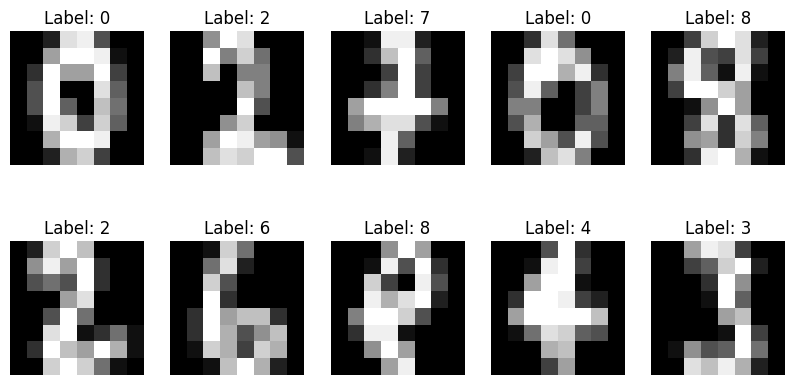

In [ ]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

# Train the CNN Model

In [ ]:
# Train the CNN
cnn = CNN()
train_losses, val_losses = cnn.train(X_train, y_train_encoded, X_val, y_val_encoded, epochs=100, learning_rate=0.01)

Epoch 0, Train Loss: 2.0122, Val Loss: 1.7643
Epoch 10, Train Loss: 0.3761, Val Loss: 0.4168
Epoch 20, Train Loss: 0.2774, Val Loss: 0.3450
Epoch 30, Train Loss: 0.1972, Val Loss: 0.4657
Epoch 40, Train Loss: 0.1882, Val Loss: 0.3819
Epoch 50, Train Loss: 0.2140, Val Loss: 0.2080
Epoch 60, Train Loss: 0.1788, Val Loss: 0.3087
Epoch 70, Train Loss: 0.1597, Val Loss: 0.2365
Epoch 80, Train Loss: 0.1428, Val Loss: 0.3062
Epoch 90, Train Loss: 0.0778, Val Loss: 0.2294


# Plot Training and Validation Loss

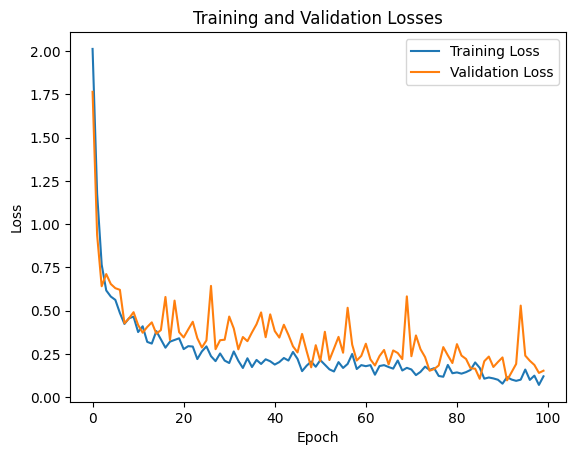

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Perform Prediction

In [ ]:
# Make predictions
y_pred = cnn.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9667
Precision: 0.9682
Recall: 0.9667


# Define PyTorch CNN Model

In [ ]:
class PyTorchCNN(nn.Module):
    def __init__(self):
        super(PyTorchCNN, self).__init__()

        # First convolutional layer: 1 input channel → 4 output channels, 3x3 kernel with padding=1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions by 2 (2x2 pooling)

        # Second convolutional layer: 4 input channels → 8 output channels, 3x3 kernel with padding=1
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()

        # Flatten layer to reshape 2D feature maps into a 1D feature vector
        self.flatten = nn.Flatten()
        # Fully connected (dense) layer: Takes input of size (8 * 2 * 2) and outputs 10 class scores
        self.fc = nn.Linear(in_features=8 * 2 * 2, out_features=10)

    def forward(self, x):
        x = self.pool(self.relu1(self.conv1(x)))  # First conv layer → ReLU → MaxPool
        x = self.pool(self.relu2(self.conv2(x)))  # Second conv layer → ReLU → MaxPool
        x = self.flatten(x)  # Flatten the feature maps to a vector
        x = self.fc(x)  # Fully connected layer for classification
        return x


In [ ]:
# Printing model summary
from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_to_analyse = PyTorchCNN().to(device)
print(model_to_analyse)

summary(model_to_analyse, (1, 8, 8))

PyTorchCNN(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=32, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 4, 8, 8]              40
              ReLU-2              [-1, 4, 8, 8]               0
         MaxPool2d-3              [-1, 4, 4, 4]               0
            Conv2d-4              [-1, 8, 4, 4]             296
              ReLU-5              [-1, 8, 4, 4]               0
         MaxPool2d-6              [-1, 8, 2, 2]               0
           Flatten-7                   [-1, 32]               0
            Linear-8             

# Train PyTorch CNN Model

In [ ]:
# Convert dataset to PyTorch tensors
X_train = X_train.reshape(-1, 1, 8, 8).astype(np.float32)
X_val = X_val.reshape(-1, 1, 8, 8).astype(np.float32)
X_test = X_test.reshape(-1, 1, 8, 8).astype(np.float32)
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
X_test = torch.from_numpy(X_test)

y_train_encoded = torch.from_numpy(y_train_encoded).float()
y_val_encoded = torch.from_numpy(y_val_encoded).float()

In [ ]:
#Initialize Model, Optimizer and Loss Function
model = PyTorchCNN()
optimizer = optim.SGD(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [ ]:
# Training loop
train_losses = []
val_losses = []
epochs = 100
for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for i in range(len(X_train)):
        x = X_train[i].unsqueeze(0)
        y = y_train_encoded[i].unsqueeze(0)
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    train_losses.append(epoch_train_loss / len(X_train))

    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for i in range(len(X_val)):
            x = X_val[i].unsqueeze(0)
            y = y_val_encoded[i].unsqueeze(0)
            output = model(x)
            loss = criterion(output, y)
            epoch_val_loss += loss.item()
    val_losses.append(epoch_val_loss / len(X_val))

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")


Epoch 0, Train Loss: 1.6809, Val Loss: 1.0732
Epoch 10, Train Loss: 0.0931, Val Loss: 0.1935
Epoch 20, Train Loss: 0.0378, Val Loss: 0.3303
Epoch 30, Train Loss: 0.0146, Val Loss: 0.1431
Epoch 40, Train Loss: 0.0057, Val Loss: 0.1455
Epoch 50, Train Loss: 0.0035, Val Loss: 0.1556
Epoch 60, Train Loss: 0.0023, Val Loss: 0.1593
Epoch 70, Train Loss: 0.0018, Val Loss: 0.1611
Epoch 80, Train Loss: 0.0014, Val Loss: 0.1616
Epoch 90, Train Loss: 0.0011, Val Loss: 0.1629


# Plot Training and Validation Losses

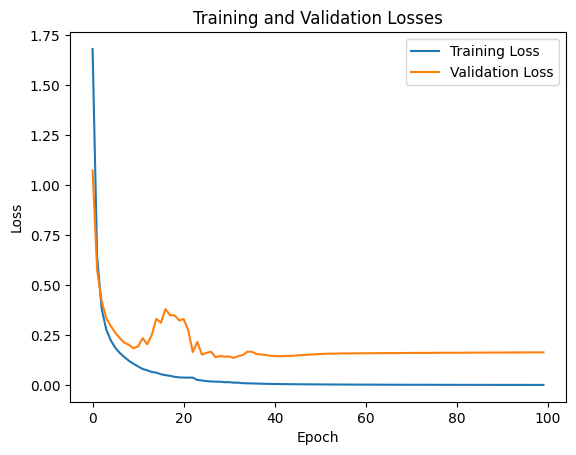

In [ ]:
# Plot training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Evaluate PyTorch Model

In [ ]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test).argmax(dim=1).numpy()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9889
Precision: 0.9893
Recall: 0.9889
